# Lab 1: Pansharpening
 **ISAT, EPITA**

 - Alexandre Bourquelot (alexandre.bourquelot)
 - Ilan Guenet (ilan.guenet)

## Information on the lab session

### Introduction
In this lab you will work directly on this notebook.
You will be required to:
- develop parts of code
- run some tests and analyse the results
- submit a report (the notebook with your answers filled in)

You can work in groups of two.

### Work during the session
- Rename the notebook adding your names
- Fill in your name/s in the first cell of the notebook
- Start reading the notebook, answer the questions, run the code, and write your own when needed
- When you are done, export the notebook in `pdf` (File -> Export Notebook As -> PDF)
- Create a compressed file including the notebook in `pdf` and in `ipynb` (this file), name it "**ISAT_labX-Name1_Name2**" (with X the n. of the lab)
- Submit your notebook in Chamilo (see below)

### Submission
The submission is done by sending the compressed folder to `mauro.dalla-mura@gipsa-lab.grenoble-inp.fr`. One submission per group.

The submission can take place in two steps.
1. **[Mandatory]** Submit your work **at the end of the session**.
2. **[Optional]** If you want to answer to additional questions (e.g., optional ones), you can submit a second version **within one week**. This second version will give up to 5 points wrt to the first submission.

# 1. Introduction

Passive (optical) very high resolution (VHR) satellites are equipped with two sensors acquiring two images of complementary characteristics.
- PAN: Panchromatic image (high spatial resolution, 1 band)
- MS: Multispectral image (low spatial resolution, ~3-16 bands)

This lab session is about **pansharpening**, i.e., the sharpening of a MS using the higher spatial resolution details in the PAN.
This can be seen as a particular problem of data fusion since one would aim at combining in a single product the spatial details resolved by the PAN (but not present in the MS) and the several spectral bands of the MS image (against the single band of the PAN). With respect to the general problem of multisensor fusion, pansharpening could not require the challenging phase of spatial coregistration since typically the images are acquired simultaneously being the PAN and MS sensors both mounted on the same platform.

In this lab session we will use *simulated data* obtained by degrading the resolution of real acquisitions.
This allows to have both a PAN and MS but also a reference MS (the MS at the original resolution).

## Notation

- $\mathbf{P}$: PAN image
- $\mathbf{M}$: MS image
- $\mathbf{M}^*$: High resolution MS image used as reference for evaluation (in real case scenarios **we don't have this image**)
- $\mathbf{S}$: Result of pansharpening. $\mathbf{S}$ should be as close as possible to $\mathbf{M}^*$

**Note** The original image $\mathbf{M}$ is 4 times smaller than the PAN. In this lab we will consider an image MS that has been already upsampled (e.g., with bicubic interpolation) in order to have the same size of the PAN image.

**Question** Write in few lines what is the physical limitation for having a single sensor of both high spectral and high spatial quality.

**Answer**:
For a single sensor, a higher spatial resolution needs a longer exposure time and a low spatial resolution needs a short exposure time. Therefore, a tradeoff needs to be decided between the resolution and the exposure time. In the case of high spatial quality the exposure time is long. In high spectral image the exposure time is short.

# 1.1 Needed packages

This cells contains all the packages and functions that are needed for executing all the cells of this notebook. Please feel free to add new `import` statements to customize the code and to make new additional experiments. 

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage import img_as_float


from skimage.color import rgb2hsv, hsv2rgb


In [2]:
# Helper functions
def check_img_dimensions(x, y):
    """Check if two images have the same dimensions"""
    assert x.shape==y.shape, "Images have not the same dimension"

def norm_minmax(x, lower, upper):
    """Normalize an array to a given bound interval"""

    x_max = np.max(x)
    x_min = np.min(x)

    m = (upper - lower) / (x_max - x_min)
    x_norm = (m * (x - x_min)) + lower

    return x_norm

def norm_std(x, m, s):
    """Normalize an array in order to have a given mean and std"""

    x_norm = s * (x - x.mean(axis=(0,1))) / x.std(axis=(0,1)) + m

    return x_norm

def norm_minmax_img(x, y):
    """Normalize an array to a given bound interval given by image y"""
    check_img_dimensions(x, y)

    y_max = np.max(y)
    y_min = np.min(y)

    x_norm = norm_minmax(x, y_min, y_max)
    return x_norm

def norm_std_img(x, y):
    """Normalize an image x in order to have a given mean and std from image y"""
    check_img_dimensions(x, y)

    if x.ndim > 2:
        x_norm = x
        for i in range(x.shape[2]):
            x_norm[:,:,i] = norm_std_img(x[:,:,i], y[:,:,i])
        return x_norm
    else:
        y_mean = y.mean(axis=(0,1))
        y_std = y.std(axis=(0,1))

        # print(y_mean, y_std)

        x_norm = norm_std(x, y_mean, y_std)
        return x_norm

def img_stats(I):
    """Print image statistics"""
    if I.ndim > 2:
        for i in range(I.shape[2]):
            print('Band {:d}'.format(i))
            img_stats(I[:,:,i])
    else:
        print('Mean: %.3f' %I.mean(axis=(0,1)))
        print('Std: %.3f' %I.std(axis=(0,1)))
        print('Min: {:.3f}, Max: {:.3f}'.format(I.min(axis=(0,1)), I.max(axis=(0,1))))

def imshow_bands(I, cmap="gray"):
    """Display the bands of an image"""

    nbands = I.shape[2]
    plt.figure(figsize=(20, 6))
    for i in range(nbands):
        plt.subplot(100 + nbands*10 + i+1)
        plt.imshow(I[:,:,i], cmap=cmap)
        plt.colorbar()
        plt.title("Band %d" %i)
    plt.show()


def imshow_stretch(I, stretchval=0.1, cmap="gray", ax=None):
    """Show a grayscale or RGB image after performing a stretching of its dynamic"""
    nbins = 1000
    tol_low = stretchval
    tol_high = 1-stretchval
    Iadj = np.zeros(I.shape)

    n_bands = 1 if len(I.shape) < 3 else I.shape[2]
    for i in range(n_bands):
        tmp = I if n_bands == 1 else I[:,:,i]
        tmp = tmp - np.min(tmp.ravel())
        tmp = tmp / np.max(tmp.ravel())
        N, _ = np.histogram(tmp.ravel(), nbins)
        cdf = np.cumsum(N)/np.sum(N)  # cumulative distribution function
        ilow = np.where(cdf > tol_low)[0][0]
        ihigh = np.where(cdf >= tol_high)[0][0]
        ilow = (ilow - 1)/(nbins-1)
        ihigh = (ihigh - 1)/(nbins-1)
        li = ilow
        lo = 0
        hi = ihigh
        ho = 255
        shape = tmp.shape
        out = (tmp < li) * lo
        out = out + np.logical_and(tmp >= li, tmp < hi) * (lo + (ho - lo) * ((tmp - li) / (hi - li)))
        out = out + (tmp >= hi) * ho
        if n_bands == 1:
            Iadj = out
        else:
            Iadj[:,:,i] = out
    if ax is None:
        plt.imshow(Iadj.astype('uint8'), cmap=cmap)
    else:
        ax.imshow(Iadj.astype('uint8'), cmap=cmap)


# 1.2 Data loading and preparation

Check the size of each image `X` (num rows, num cols, num bands) by typing `X.shape`.


In [3]:
# Load MATLAB .mat file
from scipy.io import loadmat
x = loadmat('./data/Strsbrg1.mat')  # -> You can change dataset here, there are others in the folder

M = x['MS'] # Multispectral image
HM = x['HRMS'] # High resolution Multispectral image (Reference)
P = x['PAN'] # Panchromatic image

del x

sizeP = P.shape
sizeHM = HM.shape
sizeM = M.shape


print('size M:  ', M.shape)
print('size HM: ', HM.shape)
print('size P:  ', P.shape)

size M:   (1024, 1024, 4)
size HM:  (1024, 1024, 4)
size P:   (1024, 1024)


**Question** By knowing that the Ground Sampling Distance (GSD) of the PAN sensor is 0.8 m. What is the GSD of the original MS image?

**Answer**:
The GSD of the original MS image must be higher than the GSD of the PAN sensor because the resolution of the MS image is smaller than the resolution of the PAN sensor for the same distance. The orignal MS image has been interpolated to get the same resolution as the PAN sensor (which results to a blurry MS image).

1 pixel in PAN matches 4 pixels in MS image. Thus the GSD for the original MS image is $0.8 \times 4=3.2$

## 1.3 Data visualization

This part of the session is devoted to the visualization and inspection of the images we have.


* Visualize the image data
   * Look at one band of an image `X` with the function `imshow_stretch` (e.g., as in Python indexing starts from zero, if you want to see the 3rd band
you should type: `imshow_stretch(X[:,:,2])`)
  

**Note**: this instruction should be followed by `plt.show()`.

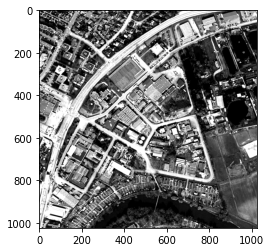

<Figure size 432x288 with 0 Axes>

In [4]:
# PAN
plt.figure
imshow_stretch(P, cmap="gray")
# plt.set_cmap('gray')  # warning: permanent!
plt.show()
plt.set_cmap('viridis')  # restore the old colormap for future plots

**Question** The MS contains four spectral bands three in the visible domain (centered on the red, green and blue wavelenghts) and one in the near infrared. Show each band separately and try to identify them. Which is the right order of the spectral bands for showing a **true color** image (an image that have "real looking" colors)? Below we have used a sequence (1,2,3) just as an example.

*Your answer here*

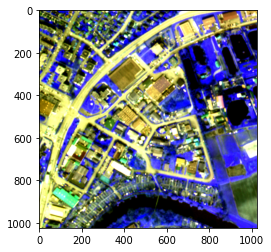

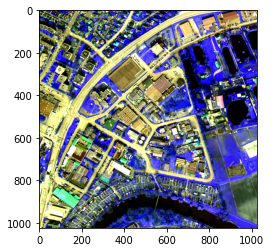

In [5]:
# example:
bands = (1,2,3)

# MS
plt.figure()
imshow_stretch(M[:,:,bands], cmap=None) # -> this is clearly not a "true color" composition

# High res MS -> This is a reference image, usually we don't have it!
plt.figure()
imshow_stretch(HM[:,:,bands], cmap=None)


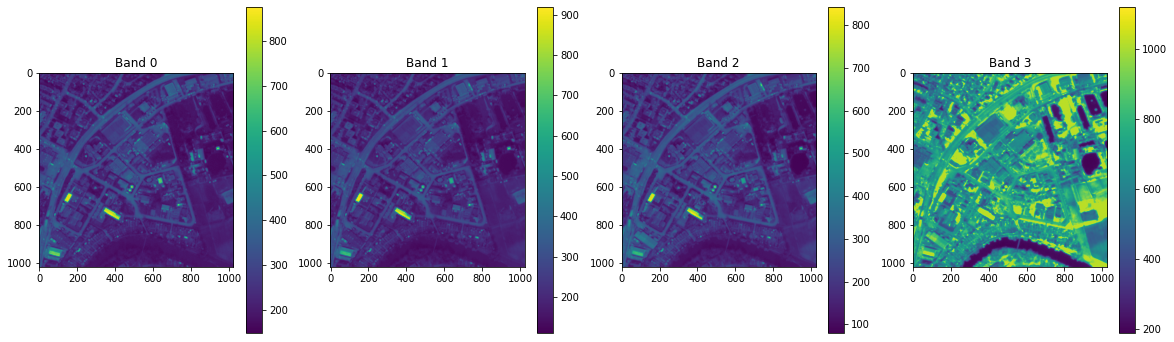

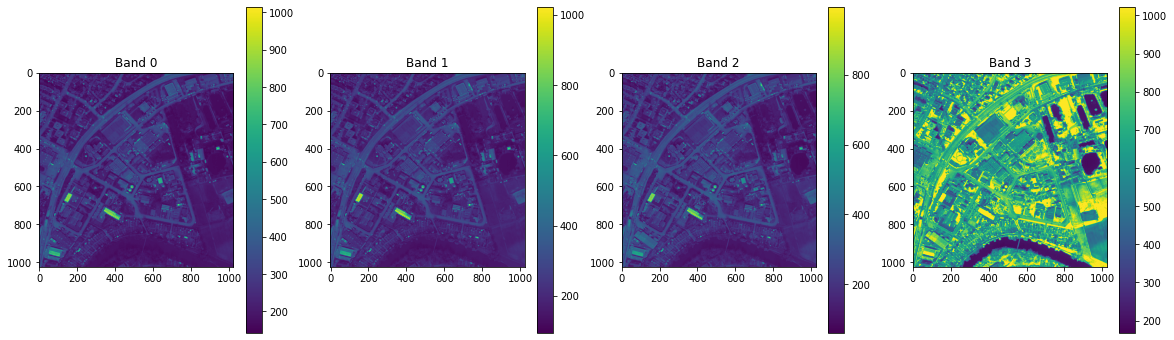

In [6]:
imshow_bands(M, cmap="viridis")
imshow_bands(HM, cmap="viridis")

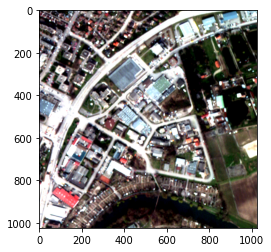

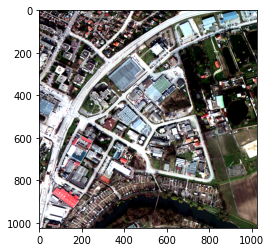

In [7]:
# From the upper cells, it seems:
# * 2 -> red
# * 1 -> green
# * 0 -> blue
# From the light spectrum and invert it.
bands = (2,1,0)

# MS
plt.figure()
imshow_stretch(M[:,:,bands], cmap=None)

plt.figure()
imshow_stretch(HM[:,:,bands], cmap=None)
# The output looks good.


## 1.4 Validation
As we have a reference image HM we can then compare the results obtained by pansharpening with respect to it.
The goal is thus to have an image resulting from pansharpening which is as close as possible to HM.

As quality indexes we will use:
- Mean Square Error (MSE). Best value 0
- Structure Similarity Index (SSIM). Best value 1
These two indexes are contained in the function `evaluate` defined below.

Test the indexes by comparing the MS image (upsampled) **M** and the reference **HM**. This will be a baseline as there is no fusion with the PAN image in this case. Pansharpening should produce images of greater quality (lower MSE and higher SSIM) than this one. 

In [8]:
def evaluate(S, HM, print_=True):
    """Evaluate how close is the image S to the reference HM"""
    mse_img = mean_squared_error(S, HM)
    ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)

    if print_:
        print('MSE: %.3f' %mse_img)
        print('SSIM: %.3f' %ssim_img)
    return mse_img, ssim_img

# Evaluate how close is the original image M with the reference HM
evaluate(M, HM)


/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 2970.020
SSIM: 0.757


(2970.020092725754, 0.7566004782343219)

# 2. Component Substitution
This part of the lab will be devoted to the so-called Component Substitution family of pansharpening techniques.

This family is based on the projection of the MS image into another space, on the substitution of the PAN with one or more components of the transformed image and then on the inverse transform in the original space.

<img src="FlowchartCS.png" alt="CS" style="width: 500px;"/>

## 2.1 Introduction

In more details, considering the MS in matrix format ($\mathbf{M} = \left[\mathbf{M}_1, \dots, \mathbf{M}_N  \right]^T$, with $\mathbf{M}_i$ the i-th channel of the MS in a row vector format) and denoting by $\mathbf{X}$ the MS transformed by a generic linear transformation $A$, the forward transformation can be written as:
\begin{equation}\label{eq:CSforward}
 \mathbf{X} =A\mathbf{M},
\end{equation}

The assumption is that the transformation $A$ separates the spatial structure from the spectral information in different components that are decoupled.  
For example, we can consider the case in which the first component carries the spatial information and this can be considered as a low-pass version of the PAN image ($\mathbf{I}$): $\mathbf{X} = [\mathbf{X_1}, \mathbf{X}_2, \dots \mathbf{X}_{N}]^T$ with $\mathbf{X_1} \approx \mathbf{I}$.
According to this representation, the fusion of the MS with PAN takes place by substituting the components carrying spatial information (in this case, the first component) with the PAN: 
$$\mathbf{Y} = [\mathbf{P}, \mathbf{X}_2, \dots \mathbf{X}_{N}]^T.$$

Then, the inverse transformation is applied on $\mathbf{Y}$ in order to obtain the pansharpened result:
\begin{equation}\label{eq:CSinverse}
\mathbf{S} = A^{-1} \mathbf{Y}.
\end{equation}

## 2.2 An illustrative example on RGB images

One of the first approaches that appeared considered as transformation $A$ the mapping from the RGB to the HSV color space.
The HSV aims at decoupling the spatial information which is contained in the component Value (V) to the spectral (color) components Hue (H) and Saturation (S).

Implement in the following the Component Substitution scheme presented before and evaluate the results.

**Hint** You can use `rgb2hsv` and `hsv2rgb` for converting from a color space to the other.


**Question** Show that the spatial and spectral components in the HSV color space are "more decoupled" with respect to in the original RGB space.

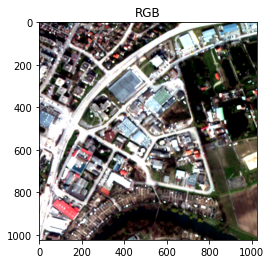

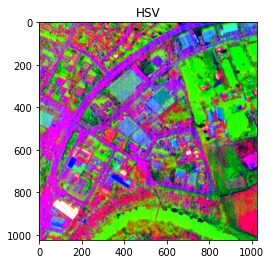

In [9]:
M_rgb = M[..., bands]
M_hsv = rgb2hsv(M_rgb)

imshow_stretch(M_rgb)
plt.title("RGB")
plt.show()
imshow_stretch(M_hsv)
plt.title("HSV")
plt.show()

In [10]:
corr_rg = np.corrcoef(M_rgb[..., 0].flatten(), M_rgb[..., 1].flatten())[0, 1]
corr_gb = np.corrcoef(M_rgb[..., 1].flatten(), M_rgb[..., 2].flatten())[0, 1]
corr_rb = np.corrcoef(M_rgb[..., 0].flatten(), M_rgb[..., 2].flatten())[0, 1]
corr_rg, corr_gb, corr_rb

(0.9621699442476519, 0.9873308015026283, 0.9513929275721068)

In [11]:
corr_hs = np.corrcoef(M_hsv[..., 0].flatten(), M_hsv[..., 1].flatten())[0, 1]
corr_sv = np.corrcoef(M_hsv[..., 1].flatten(), M_hsv[..., 2].flatten())[0, 1]
corr_hv = np.corrcoef(M_hsv[..., 0].flatten(), M_hsv[..., 2].flatten())[0, 1]
corr_hs, corr_sv, corr_hv

(-0.2789725633223477, -0.5103196428995718, 0.15643763315454004)

The RGB channels are much more correlated than HSV channels.
Specifically, the V and H channel are strongly decorrelated (0.15).

## 2.3 Component Substitution in a general formulation


### General formulation
A more general formulation of the CS fusion scheme is given by
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}+g_{k}\left(
\mathbf{P}-\mathbf{I}\right)  , \label{eq:genaralInjectionModel}%
\end{equation}
in which the subscript $k$ indicates the $k$-th band, $\mathbf{g}=[g_{1},\dots,g_{k}%
,\dots,g_{N}]$ is the vector of the **injection gains**, while, $\mathbf{I}$ is defined as follows:
\begin{equation}
\mathbf{I}= \sum_{i=1}^N w_{i}\mathbf{M}_{i}, \label{eq:linearPLP}%
\end{equation}
where the **weights** $\mathbf{w}=[w_{1},\dots,w_{i},\dots,w_{N}]$ measure the spectral overlap among the spectral bands and the panchromatic
image $\mathbf{P}$.

**[Optional] Question:**

Prove that the process reported above can be equivalently obtained by the component substitution in Sec. 2.1.
Is there an advantage in using this generic formuation with respect the scheme in Sec. 2.1?

**Question** Give a brief comment on the role of the coefficients $\mathbf{g}$ and $\mathbf{w}$ in the fusion process.

**Answer**:
* $g$: each band has different impact of the value on the resulting image
* $w$: how much the $w_i$ is close to the unique band of P

In [12]:
# -> Your code here

## 2.4 Generalized HSI scheme
You will implement a scheme that is similar to the previous HSV transformation done on the RGB image but with the generalized scheme presented in Sec. 2.3

In particular you will consider that $w_i = 1/N$ for all $i$ and $g_k = 1 $ for all $k$.

In [13]:
# -> Your code here
n_bands = M.shape[-1]
w = np.full(n_bands, 1 / n_bands) # Vector of 1 / N
g = np.ones(n_bands) # Vector of 1

def compute_generalized_hsi(M, P, g=g, w=w, norm=False):
    I = M @ w.T
    if norm:
        P = norm_std_img(P, I)
    P_I = P - I
    P_I = np.expand_dims(P_I, axis=-1)

    S = M + g * P_I
    return S

In [14]:
S_generalized = compute_generalized_hsi(M, P, g=g, w=w)

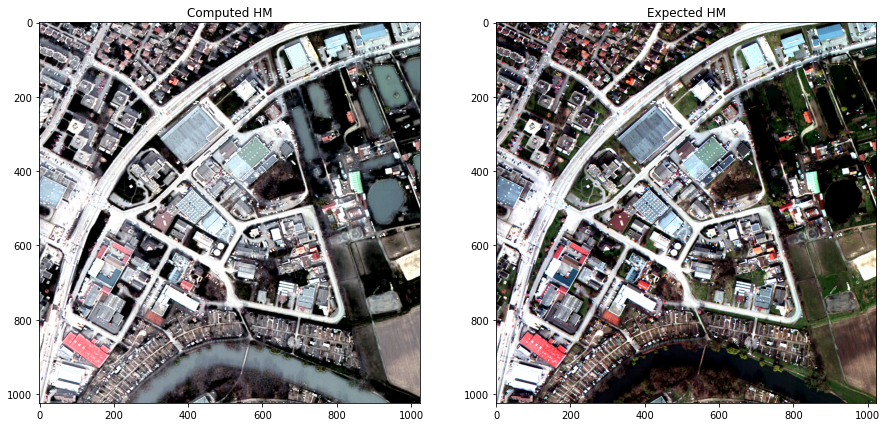

In [15]:
def show_hsi_result(S, HM, bands=bands):
    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.title("Computed HM")
    imshow_stretch(S[..., bands])

    plt.subplot(122)
    plt.title("Expected HM")
    imshow_stretch(HM[..., bands])

show_hsi_result(S_generalized, HM)

CS techniques can be affected if the range of the PAN and the MS images differ. This happens quite often as they are acquired by different sensors.
Try to perform a normalization of the PAN image in order to force it to have the same dynamic of $\mathbf{I}$. 

**Hint** Use the `norm_std_image` defined at the beginning of the file.

**Question** Compare the case with and without normalization.

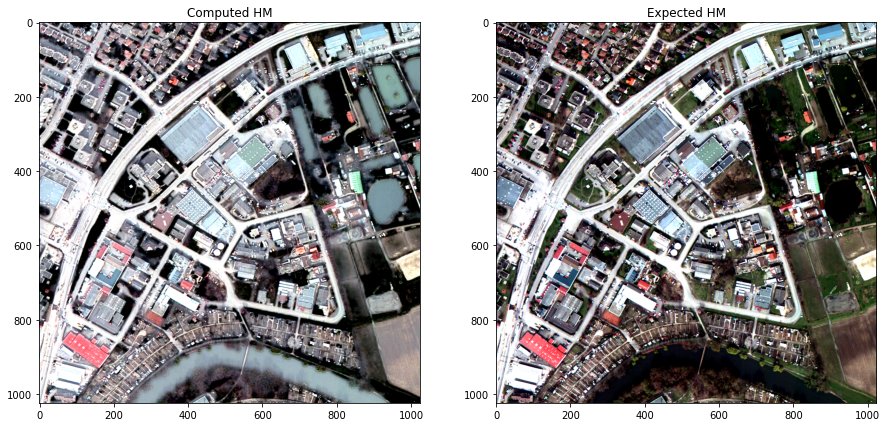

In [16]:
# -> Your code here

S_generalized_norm = compute_generalized_hsi(M, P, g=g, w=w, norm=True)
show_hsi_result(S_generalized_norm, HM)

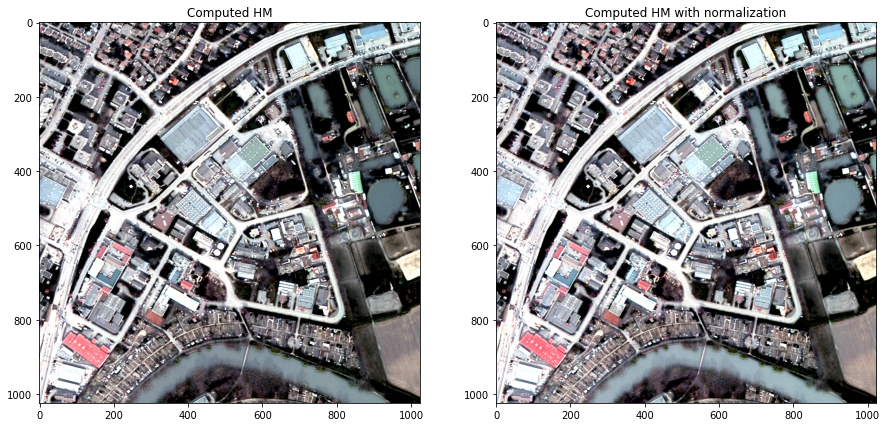

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.title("Computed HM")
imshow_stretch(S_generalized[..., bands])

plt.subplot(122)
plt.title("Computed HM with normalization")
imshow_stretch(S_generalized_norm[..., bands])

In [18]:
evaluate(S_generalized, HM)
evaluate(S_generalized_norm, HM)

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 12501.855
SSIM: 0.658
MSE: 3918.963
SSIM: 0.824


(3918.9630347915654, 0.8241905469176003)

**The normalization hsi scheme has better evaluation scores. But visually, we can't really the difference.**

## 2.5 Multiplicative injection scheme
An alternative way to sharpen the MS with the details fo the PAN is based on a multiplicative scheme for injecting the spatial details.
The fused image is defined, for $k=1,\dots,N$, as:
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}\cdot\frac{\mathbf{P}%
}{\mathbf{I}}. \label{eq:HPM}%
\end{equation}
being the operators applied point-wise on the matrices.

**Question** Implement this scheme and compare it with the previous additive injection model.

**[Optional] Question** Prove that this can be equivalently expressed as 
  \begin{equation}
  \mathbf{S}_{k}=\mathbf{M}_{k}+\frac{\mathbf{M}_{k}}{\mathbf{I}}\cdot(\mathbf{P}-\mathbf{I}),
  \end{equation}
 
  by setting, for $k=1,\dots,N$,
  \begin{equation}
  g_{k}=\frac{\mathbf{M}_{k}}{\mathbf{I}}.
  \end{equation}
  
**Hint** Elementwise division between two arrays `A` and `B` can be performed by `np.divide(A, B)` (or `A/B`). Elementwise multiplication can be done by `np.multiply(A, B)` (or `A*B`).

In [19]:
# -> Your code here

def compute_multiplicative_scheme(M, P, w=w, norm=False):
    I = M @ w.T
    if norm:
        P = norm_std_img(P, I)
    P_I = P / I
    P_I = np.expand_dims(P_I, axis=-1)

    S = M * P_I
    return S



In [20]:
S_multiplicative = compute_multiplicative_scheme(M, P, w=w, norm=False)
S_multiplicative_norm = compute_multiplicative_scheme(M, P, w=w, norm=True)
S_multiplicative.shape, S_multiplicative_norm.shape

((1024, 1024, 4), (1024, 1024, 4))

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 19398.123
SSIM: 0.816
MSE: 5253.060
SSIM: 0.848


(5253.059692982619, 0.8481742570422984)

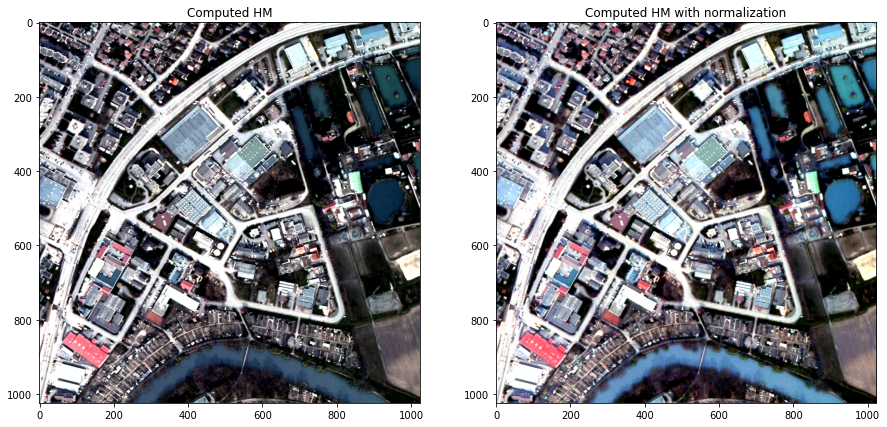

In [21]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.title("Computed HM")
imshow_stretch(S_multiplicative[..., bands])

plt.subplot(122)
plt.title("Computed HM with normalization")
imshow_stretch(S_multiplicative_norm[..., bands])

evaluate(S_multiplicative, HM)
evaluate(S_multiplicative_norm, HM)

In [22]:
evaluate(S_generalized_norm, HM)
evaluate(S_multiplicative_norm, HM)

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 3918.963
SSIM: 0.824
MSE: 5253.060
SSIM: 0.848


(5253.059692982619, 0.8481742570422984)

* In terms of MSE, the generalized HSI scheme has better score. On the other hand, the SSIM score is better for the multiplicative injection scheme
* Both methods show better result with normalized data (normalization of P with respect to I).

### MultiResolution Analysis (MRA)

In the second class of pansharpening methods the contribution
of the PAN image to the fused product is achieved by calculating the
difference between $\mathbf{P}$ and a low pass version $\mathbf{P}_{L}$.
Namely the HRMS image is defined as
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}+g_{k}\left(
\mathbf{P}-\mathbf{P}_{L}\right),\ \forall k=1,\dots,N \label{eq:MRA}%
\end{equation}
This paradigm has been denoted as *Amélioration de
la Résolution Spatiale par Injection de Structures* (*ARSIS*)
underlining that the purposes of these methods are the preservation of the
whole content of the LRMS image and the addition of further information
obtained from the PAN image, through spatial filtering.

According to definition the different approaches belonging to
this class are uniquely characterized by the algorithm employed for obtaining
the image $\mathbf{P}_{L}$ and by the combination coefficients $\left\{
g_{k}\right\}_{k=1,\ldots,N}$.

In a very general setting, $\mathbf{P}_{L}$ is achieved through an iterative
decomposition scheme (called MRA) aiming at constructing a sequence of signals with successively
reduced information (or \textit{pyramid}), through the repeated application of
the analysis operators. The type of decomposition constitutes a first
distinguishing feature of the various approaches and can range from very simple
methods based on a single level decomposition to more complex techniques relying upon a multilevel analysis.

In addition, the mathematical expression of $\mathbf{g}$ assumes different
forms in the literature, among which two options are the most commonly reported.
By setting all the coefficients equal to $1$ the \textit{additive} injection scheme is achieved:%
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}+\left(  \mathbf{P}%
-\mathbf{P}_{L}\right)  ,\ \forall k=1,\dots,N. \label{eq:HPFModel}%
\end{equation}
The \textit{High Pass Modulation} (\textit{HPM}) method (also called \textit{multiplicative} injection scheme) is the other
well-known paradigm, defined through the expression
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}+\frac{\mathbf{M}_{k}}{\mathbf{P}_{L}}\left(  \mathbf{P}-\mathbf{P}_{L}\right)
,\ \forall k=1,\dots,N, \label{eq:HPMModel}%
\end{equation}
in which the details are weighted by the ratio of the MS and the
PAN low pass version $\mathbf{P}_{L}$, with the aim of reproducing, in the
fused image, the local intensity contrast of the PAN. 

<img src="FlowchartMRA.png" alt="MRA" style="width: 500px;"/>


The flowchart is slightly simpler than for CS. In fact, as one can notice, it lacks the block aimed at estimating the weight vector $\mathbf{w}$, needed for the construction of the equivalent panchromatic image.
Accordingly, the required blocks are devoted to: i) Upsample the MS image to reach the panchromatic resolution; ii) Perform the pyramidal decomposition yielding the low pass version $\mathbf{P}_{L}$ of the PAN image; iii)
Compute the band dependent injection gains $\left\{  g_{k}\right\}
_{k=1,\ldots,N}$; iv) Inject the extracted details.


### Low pass filtering

The most direct implementation of the ARSIS concept consists in applying a
single Linear Time-Invariant (LTI) Low Pass Filter (LPF) $h_{LP}$ to the PAN image $\mathbf{P}$ for obtaining $\mathbf{P}_{L}$, thus resulting in the following formula
\begin{equation}
\mathbf{S}_{k}=\mathbf{M}_{k}+g_k\left(  \mathbf{P}%
-\mathbf{P}\ast h_{LP}\right)  ,\ \forall k=1,\dots,N, \label{eq:HPF2}%
\end{equation}
in which $\ast$ denotes the convolution operator.

This approach can be performed by employing several different
low pass filters $h_{LP}$, among which the most diffused uses Box, Gaussian and Laplacian masks. Furthermore, the simple additive injection scheme  or more elaborated alternatives can be exploited for injecting the spatial details. 

Among the possible couples of filters and coefficients, we chose the simplest scheme achievable by using the Box mask (i.e., mask with uniform weights, implementing an average filter) and additive injection, which leads to the pansharpening algorithm known as *High Pass Filtering* (*HPF*) method. 

The corresponding methodology employing the HPM injection scheme has been also proposed.

**Question**
- Implement and test this technique using a conventional average filter.
- Test both the additive and multiplicative schemes.

In [23]:
# -> Your code here
import scipy.signal

def compute_multiresolution_analysis(M, P, g=g, filter_size=5, norm=False, additive=True):
    kernel = np.full((filter_size, filter_size), 1 / (filter_size * filter_size))
    P_l = scipy.signal.convolve2d(P, kernel, mode='same')

    if norm:
        P = norm_std_img(P, P_l)

    if additive:
        P_diff = P - P_l
        P_diff = np.expand_dims(P_diff, axis=-1)
        S = M + g * P_diff
    else:
        P_diff = P / P_l
        P_diff = np.expand_dims(P_diff, axis=-1)
        S = M * P_diff
    return S

In [24]:
evaluate(compute_multiresolution_analysis(M, P, g=g, norm=False, additive=True), HM)
evaluate(compute_multiresolution_analysis(M, P, g=g, norm=True, additive=True), HM) # Do not normalize
evaluate(compute_multiresolution_analysis(M, P, g=g, norm=False, additive=False), HM)
evaluate(compute_multiresolution_analysis(M, P, g=g, norm=True, additive=False), HM) # Do not normalize

# The best parameters are no normalization and additive scheme

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 1891.457
SSIM: 0.890
MSE: 2123.685
SSIM: 0.880
MSE: 2569.441
SSIM: 0.888
MSE: 2736.327
SSIM: 0.879


(2736.327040079037, 0.8792308917245308)

In [25]:
S_multiresolution_additive = compute_multiresolution_analysis(M, P, g=g, norm=False, additive=True)

In [26]:
evaluate(S_generalized_norm, HM)
evaluate(S_multiplicative_norm, HM)
evaluate(S_multiresolution_additive, HM)

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


MSE: 3918.963
SSIM: 0.824
MSE: 5253.060
SSIM: 0.848
MSE: 1891.457
SSIM: 0.890


(1891.4569067691805, 0.8895813945363972)

**The best scheme is the multiresolution with additive**


**[Optional] Question**
- Test different filters (Gaussian, laplacian,...)

**Question** The choice of the filter size is critical. Make a comparison when changing the size of the filter. Perform an analysis of the filters in the frequency domain and discuss the observed spectra with respect to the corresponding obtained results.
**Hint** If a filter is isotropic, you may consider only a 1D profile.

In [27]:
all_mse = []
all_ssim = []
range_ = range(1, 10)

for i in range_:
    mse_, ssim_ = evaluate(compute_multiresolution_analysis(M, P, g=g, filter_size=i, norm=False, additive=True), HM, print_=False)
    all_mse.append(mse_)
    all_ssim.append(ssim_)

all_mse = np.array(all_mse)
all_ssim = np.array(all_ssim)

/tmp/ipykernel_90110/1655000788.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_img = ssim(S, HM, data_range=HM.max() - HM.min(), multichannel=True)


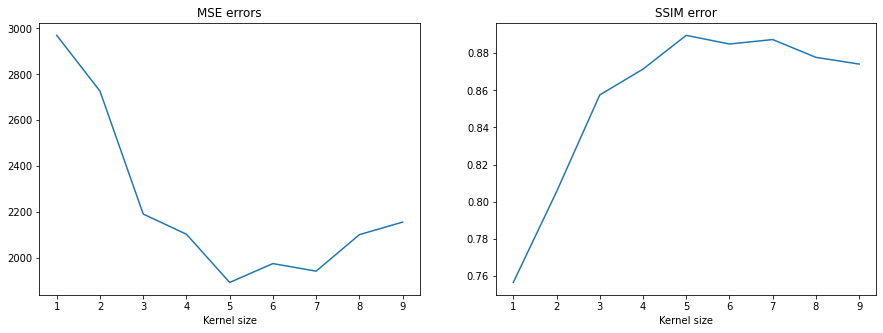

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range_, all_mse)
plt.title("MSE errors")
plt.xlabel("Kernel size")
plt.subplot(122)
plt.title("SSIM error")
plt.xlabel("Kernel size")
plt.plot(range_, all_ssim)